# Example Features of DictRep Class

In [1]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import timeit
sys.path.append("..")

In [2]:
from dictrep import DictRep
from dwavetools import find_heff_s, make_anneal_schedule, create_heff_csv

## Single Problem Logical Encoding Hamiltonain (spleH)

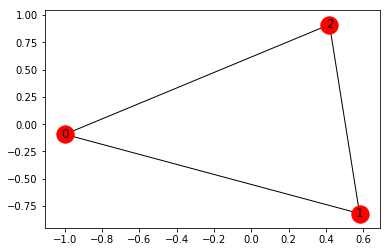

In [3]:
spleH = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): 0.1}
problem1 = DictRep(H = spleH, qpu = 'dwave', vartype = 'ising', encoding = "logical")
problem1.visualize_graph()

In [6]:
response1 = problem1.call_annealer() #returns default OCEAN output object
totaloutput = []
for energy, state, n in response1.data(['energy', 'sample', 'num_occurrences']):
    nthdata = [energy, state, n]
    totaloutput.append(nthdata)
print(totaloutput[0])
print(totaloutput[-1])
print(len(totaloutput))

[-0.4, {0: -1, 1: -1, 2: -1}, 1]
[0.20000000000000004, {0: 1, 1: 1, 2: 1}, 1]
246


#### Explanation
With logical encoding specified, qubits are minor-embedded with internal D-Wave Ocean API. In addition, if the problem can fit more than once on the chip, the logical encoding option attempts to tile the same motif across chip to increase sample statistics in a single run. Hence, why this small problem ran 246 times on one call to the D-Wave machine.

## Single Problem Direct Encoding Hamiltonain (spdeH)

In [15]:
spdeH = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): 0.1}
problem2 = DictRep(H = spleH, qpu = 'ORNL_2000Q_2', vartype = 'ising', encoding = "direct")
response2 = problem2.call_annealer() #returns default OCEAN output object

ValueError: Problem graph incompatible with solver.

#### Explanation
Notice that using "direct" encoding with the same Hamiltonian used in the logical encoding above actually fails. This is because "direct" encoding assumes the user has created his/her own problem representation that will fit on the graph as is. If the user did the minor embedding wrong/ tries to use a qubit that is broken, the ping to the D-Wave machine will throw a ValueError. Furthermore, this option does not attempt to tile the motif--this must also be done by the user if desired.

### Abstract Problem Logical Encoding Hamiltonian (apleH)

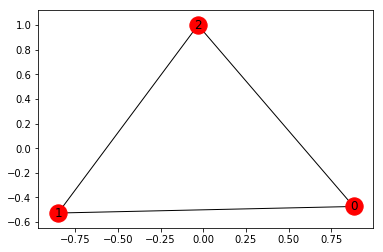

In [3]:
apleH = {(0, 0): 'h0', (1, 1): 'h0', (2, 2): 'h0', (0, 1): 'J1', (1, 2): 'J1', (0, 2): 'J2'}
problem3 = DictRep(apleH, 'simulate', 'ising', 'logical')
problem3.visualize_graph()

<module 'matplotlib.pyplot' from '/home/nic/miniconda2/envs/jupyterlab3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

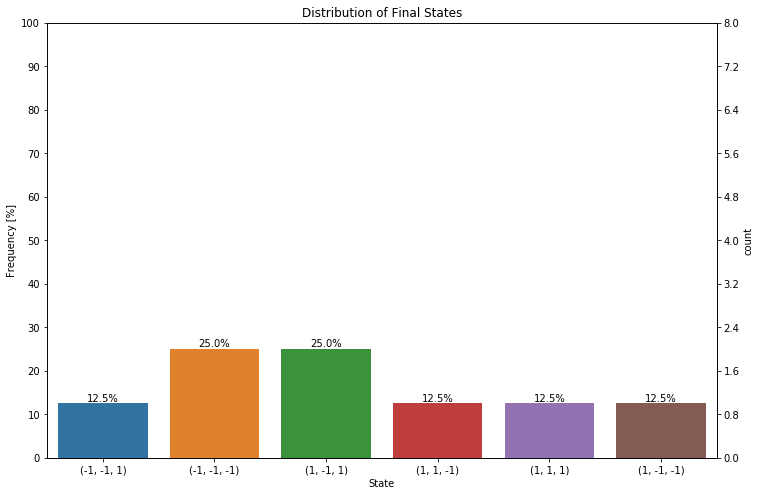

In [4]:
# Set values for abstract parameters to take
h0 = np.linspace(0, 0.1, 2)
J1 = [-.1]
J2 = np.linspace(0, 0.1, 2)

# Create anneal schedules to try
sch1 = make_anneal_schedule('forward', s = 1, ta = 20)
sch2 = make_anneal_schedule('forward', s = 1, ta = 10, tp = 5, tq = 5)

#propogate these parameters to problem3
parameters = {'h0': h0, 'J1': J1, 'J2': J2, 'anneal_schedule': [sch1, sch2], 'num_reads': [1]}
problem3.populate_parameters(parameters)
data = problem3.call_annealer(cull = False)
data.head()

#post-processing
problem3.save_data('test.csv')
problem3.get_state_plot(figsize = (12, 8), filename = 'test.png')

### Transverse Field Example

In [8]:
transH = {(0, 0): 'h0', (1, 1): 'h0', (2, 2): 'h0', (0, 1): 'J1', (1, 2): 'J1', (0, 2): 'J2'}
problem4 = DictRep(transH, 'dwave', 'ising', 'logical')
# load in chip data (simplified csv file created with dwavetools)
heff_to_s = pd.read_csv("heff_to_s_DW_2000Q_2_June2018.csv")

In [9]:
#set h/ J vals
h0 = [0]
J1 = [-.1]
J2 = np.linspace(-0.4, 0.4, 20)
#set hxvals, find corresponding svals
hxvals = np.linspace(-0.4, 0.4, 20)
hidxs = pd.Index(heff_to_s['heff'])
csv_svals = pd.Index(heff_to_s['s'])
s_to_hx = {}
svals = []
for hx in hxvals:
    s = csv_svals[hidxs.get_loc(hx, 'nearest')]
    svals.append(s)
    s_to_hx[s] = hx
    
#create anneal_schedules that correspond to quenching at s when heff = hx with various anneal lengths
atimes = [20]
schedules = [make_anneal_schedule('f', s, ta, 0, 1) for s in svals for ta in atimes]

<module 'matplotlib.pyplot' from '/home/nic/miniconda2/envs/jupyterlab3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

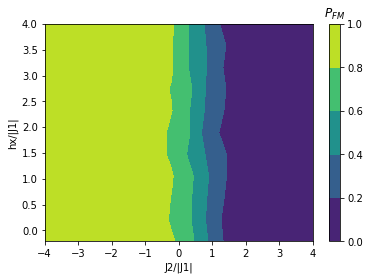

In [10]:
parameters4 = {'h0': h0, 'J1': J1, 'J2': J2, 'anneal_schedule': schedules, 'num_reads': [1]}
problem4.populate_parameters(parameters4)
data4 = problem4.call_annealer(cull = False, s_to_hx=s_to_hx)
data4.head()

problem4.get_ferro_diagram('J2', 'hx', 'J1')